## Basic imports

In [12]:
import sys
import time
from tempfile import TemporaryDirectory
from scipy import stats 
from scipy import signal
import suite2p
import numpy as np
from tifffile import TiffFile, imwrite
import seaborn as sns
import os, glob
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
import re

sys.path.append('/mnt/ssd1/ysaito/suite2p-pipeline-main/00_code/')
import ROI_postprocess_YS.postprocess as post
# import importlib
# importlib.reload(post)

## Read metainfo

In [5]:
metainfo = h5py.File(os.getcwd()+'/00_Metafile/metafile.h5', 'r')
display(metainfo['sessionInfo'].keys())

recordingDate = metainfo['sessionInfo/recordingDate'][()].decode()
mouseID = metainfo['sessionInfo/mouseID'][()].decode()
behaviorInfo = metainfo['sessionInfo/behaviorInfo'][()].decode()
recTarget = metainfo['sessionInfo/recTarget'][()].decode()
sensor = metainfo['sessionInfo/sensor'][()].decode()
fs = metainfo['sessionInfo/fs'][()]
resolution = metainfo['sessionInfo/resolution'][()]
analysisDate = metainfo['sessionInfo/analysisDate'][()].decode()


codeDir = metainfo['sessionInfo/codeDir'][()].decode()
dataDir = metainfo['sessionInfo/sessiondataDir'][()].decode()
analysisDir = metainfo['sessionInfo/analysisDir'][()].decode()+'/01_ROI_detection_DeepCAD_all' 
os.makedirs(analysisDir, exist_ok=True)
metainfo.close()

print('recording data:', recordingDate)
print('analysis data:', analysisDate)
print('behaviorInfo:', behaviorInfo)
print('sensor:', sensor)
print('recTarget:', recTarget)
print('fs:', fs)
print('resolution:', resolution)
print('dataDir:', dataDir)
print('analysisDir:', analysisDir)

<KeysViewHDF5 ['analysisDate', 'analysisDir', 'behaviorInfo', 'codeDir', 'fs', 'mouseID', 'opsin', 'recTarget', 'recordingDate', 'resolution', 'sensor', 'sessionID', 'sessiondataDir']>

recording data: 
analysis data: 2023-05-26 16:03:05.694461
behaviorInfo: 
sensor: GCaMP7.09
recTarget: Soma
fs: 7.65
resolution: 2048
dataDir: /mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01
analysisDir: /mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all


## Data

In [13]:
tiff_list = sorted(glob.glob(dataDir+'/*.tiff'))
tiff_list = sorted(tiff_list, key=lambda x: int(re.findall(r"Exp01_C1-(\d+)\.tiff", x)[0]))
print('Input')
display(dataDir)
display(tiff_list)

Input


'/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01'

['/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-0.tiff',
 '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-1.tiff',
 '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-2.tiff',
 '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-3.tiff',
 '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-4.tiff',
 '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-5.tiff',
 '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-6.tiff',
 '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-7.tiff',
 '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-8.tiff',
 '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-9.tiff',
 '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-10.tiff',
 '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-11.tiff',
 '/mnt/ssd1/ysaito/suite2p

# Suite2p

## Set parameters

In [14]:
ops = suite2p.default_ops()
print(ops)

{'suite2p_version': '0.12.1', 'look_one_level_down': False, 'fast_disk': [], 'delete_bin': False, 'mesoscan': False, 'bruker': False, 'bruker_bidirectional': False, 'h5py': [], 'h5py_key': 'data', 'nwb_file': '', 'nwb_driver': '', 'nwb_series': '', 'save_path0': [], 'save_folder': [], 'subfolders': [], 'move_bin': False, 'nplanes': 1, 'nchannels': 1, 'functional_chan': 1, 'tau': 1.0, 'fs': 10.0, 'force_sktiff': False, 'frames_include': -1, 'multiplane_parallel': False, 'ignore_flyback': [], 'preclassify': 0.0, 'save_mat': False, 'save_NWB': False, 'combined': True, 'aspect': 1.0, 'do_bidiphase': False, 'bidiphase': 0, 'bidi_corrected': False, 'do_registration': True, 'two_step_registration': False, 'keep_movie_raw': False, 'nimg_init': 300, 'batch_size': 500, 'maxregshift': 0.1, 'align_by_chan': 1, 'reg_tif': False, 'reg_tif_chan2': False, 'subpixel': 10, 'smooth_sigma_time': 0, 'smooth_sigma': 1.15, 'th_badframes': 1.0, 'norm_frames': True, 'force_refImg': False, 'pad_fft': False, 'no

In [15]:
# Set parameters
db = {
    'data_path': dataDir,
    'save_path0': analysisDir,
    'tiff_list': tiff_list,
    'fs': fs,
    'tau': 2,
    'spatial_scale':1,
    'keep_movie_raw': False,
    'do_registration': True,
    'two_step_registration': False,
    'maxregshift':0.02, #0.1
    'smooth_sigma_time':0, #0
    'maxregshiftNR':40,    #5
    'th_badframes':1,
    'block_size': [128, 128],
    'batch_size': 1000,
    'reg_tif': True,
    'subpixel':2,
    'roidetect':False,
    'threshold_scaling': 1,
    'connected': True,
    'sparse_mode': True,
    'max_iterations': 100,
    'max_overlap':0.25,
    'spikedetect': False,
}
db

{'data_path': '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01',
 'save_path0': '/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all',
 'tiff_list': ['/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-0.tiff',
  '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-1.tiff',
  '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-2.tiff',
  '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-3.tiff',
  '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-4.tiff',
  '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-5.tiff',
  '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-6.tiff',
  '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-7.tiff',
  '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-8.tiff',
  '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_E

## Motion correction

In [16]:
%%time
output_ops = suite2p.run_s2p(ops=ops, db=db)

{'data_path': '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01', 'save_path0': '/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all', 'tiff_list': ['/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-0.tiff', '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-1.tiff', '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-2.tiff', '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-3.tiff', '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-4.tiff', '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-5.tiff', '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-6.tiff', '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-7.tiff', '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-8.tiff', '/mnt/ssd1/ysaito/suite2p-pipeline-main/01_data/i166-m2_Exp01/Exp01_C1-9.tiff

In [19]:
from tifffile import TiffFile, imwrite
import re
tiff_list = sorted(glob.glob(analysisDir+'/*/*/*/*.tif'))
tiff_list = sorted(tiff_list, key=lambda x: int(re.findall(r"file(\d+)_", x)[0]))
img_all = []
for i in range(len(tiff_list)):
    with TiffFile(tiff_list[i]) as tif:
        mmap = tif.asarray(out="memmap") # read .tiff as memmap
        print(tiff_list[i])
        print('Image block size:', mmap.shape)
        img_bl = np.asarray(mmap[:, 0:2048, 0:2048])
        img_all.extend(img_bl)
img_all=np.array(img_all)
os.makedirs(analysisDir+'/suite2p/plane0/reg_tif/data_all', exist_ok=True)
imwrite(analysisDir+'/suite2p/plane0/reg_tif/data_all/registered.tif', img_all)

/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/file000_chan0.tif
Image block size: (1000, 2048, 2048)
/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/file1000_chan0.tif
Image block size: (1000, 2048, 2048)
/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/file2000_chan0.tif
Image block size: (1000, 2048, 2048)
/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/file3000_chan0.tif
Image block size: (1000, 2048, 2048)
/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/file4000_chan0.tif
Image block size: (1000, 2048, 2048)
/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/file5000_chan0.tif


In [20]:
# remove binary and ops for motion correction
os.remove(analysisDir+'/suite2p/plane0/data.bin')
os.remove(analysisDir+'/suite2p/plane0/ops.npy')

## DeepCAD -> Suite2p

In [22]:
tiff_list = sorted(glob.glob(analysisDir+'/*/*/*/DataFolderIs_*/*/*.tif'))
tiff_list = sorted(tiff_list, key=lambda x: int(re.findall(r"file(\d+)_", x)[0]))
tiff_list

['/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/DataFolderIs_reg_tif_202305271346_ModelFolderIs_data_all_202305261842/E_20_Iter_3388/file000_chan0_E_20_Iter_3388_output.tif',
 '/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/DataFolderIs_reg_tif_202305271346_ModelFolderIs_data_all_202305261842/E_20_Iter_3388/file1000_chan0_E_20_Iter_3388_output.tif',
 '/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/DataFolderIs_reg_tif_202305271346_ModelFolderIs_data_all_202305261842/E_20_Iter_3388/file2000_chan0_E_20_Iter_3388_output.tif',
 '/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/DataFolderIs_reg_tif_202305271346_ModelFolderIs_data_all_202305261842/E_20_Iter_3388/file3000_chan0_E_20_Iter_3388_output.tif',
 '/mnt/ssd1/y

In [23]:
# Set parameters
db = {
    'data_path': glob.glob(analysisDir+'/*/*/*/DataFolderIs_*')[0],
    'save_path0': analysisDir,
    'tiff_list': tiff_list,
    'fs': fs,
    'tau': 2,
    'spatial_scale':1,
    'keep_movie_raw': False,
    'do_registration': False,
    'two_step_registration': False,
    'maxregshift':0.02, #0.1
    'smooth_sigma_time':0, #0
    'maxregshiftNR':40,    #5
    'th_badframes':1,
    'block_size': [128, 128],
    'batch_size': 1000,
    'reg_tif': False,
    'subpixel':2,
    'roidetect':True,
    'threshold_scaling': 1,
    'connected': True,
    'sparse_mode': True,
    'max_iterations': 100,
    'max_overlap':0.25,
    'spikedetect': False,
}
db

{'data_path': '/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/DataFolderIs_reg_tif_202305271346_ModelFolderIs_data_all_202305261842',
 'save_path0': '/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all',
 'tiff_list': ['/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/DataFolderIs_reg_tif_202305271346_ModelFolderIs_data_all_202305261842/E_20_Iter_3388/file000_chan0_E_20_Iter_3388_output.tif',
  '/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/DataFolderIs_reg_tif_202305271346_ModelFolderIs_data_all_202305261842/E_20_Iter_3388/file1000_chan0_E_20_Iter_3388_output.tif',
  '/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/DataFolderIs_reg_tif_202305271346_ModelFolderIs_data_all

In [25]:
%%time
output_ops = suite2p.run_s2p(ops=ops, db=db)

{'data_path': '/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/DataFolderIs_reg_tif_202305271346_ModelFolderIs_data_all_202305261842', 'save_path0': '/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all', 'tiff_list': ['/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/DataFolderIs_reg_tif_202305271346_ModelFolderIs_data_all_202305261842/E_20_Iter_3388/file000_chan0_E_20_Iter_3388_output.tif', '/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/DataFolderIs_reg_tif_202305271346_ModelFolderIs_data_all_202305261842/E_20_Iter_3388/file1000_chan0_E_20_Iter_3388_output.tif', '/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/reg_tif/DataFolderIs_reg_tif_202305271346_ModelFolderIs_data_all_20230

## Load result

In [26]:
iscell = np.load(glob.glob(analysisDir+'/*/*/iscell.npy')[0], allow_pickle=True) #[:, 0].astype(bool)
np.save(analysisDir+'/suite2p/plane0/iscell_default.npy', iscell)
ROI_stats= np.load(glob.glob(analysisDir+'/*/*/stat.npy')[0], allow_pickle=True)
F = np.load(glob.glob(analysisDir+'/*/*/F.npy')[0], allow_pickle=True)
F_neuropils = np.load(glob.glob(analysisDir+'/*/*/Fneu.npy')[0], allow_pickle=True)

In [27]:
print('default classifier')
print('cell number:', len(np.where(iscell[:,0]==1)[0]))
print('non-cell number:', len(np.where(iscell[:,0]==0)[0]))

default classifier
cell number: 4862
non-cell number: 6683


## Post-processing

In [28]:
clssify_parms = {
    'ROI_size_threshold':[40, 180],
    'ROI_compact_threshold': 1.07,
    'dF_F_threshold': [1, 20],
    'snr_threshold': 0.8,
    'mad_threshold': 2.5,
}
clssify_parms

{'ROI_size_threshold': [40, 180],
 'ROI_compact_threshold': 1.07,
 'dF_F_threshold': [1, 20],
 'snr_threshold': 0.8,
 'mad_threshold': 2.5}

In [29]:
iscell_2 = np.ones([iscell.shape[0], iscell.shape[1]])

### Morphorogy

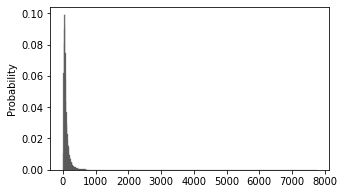

In [30]:
ROI_npix = post.extract_ROI_stats(ROI_stats, key='npix')
fig = plt.figure(figsize=(5, 3))
sns.histplot(ROI_npix, binwidth=10, stat='probability', kde=False, color='k', alpha=.5, linewidth=0.2, edgecolor='.3');

(0.9, 1.3)

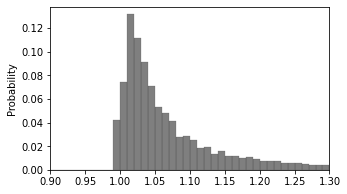

In [31]:
ROI_compact = post.extract_ROI_stats(ROI_stats, key='compact')
fig = plt.figure(figsize=(5, 3))
sns.histplot(ROI_compact, binwidth=0.01, stat='probability', kde=False, color='k', alpha=.5, linewidth=0.2, edgecolor='.3');
plt.xlim(0.9,1.3)

In [32]:
centroid = post.extract_ROI_stats(ROI_stats, key='med')[:,::-1]

In [33]:
# # Tuning thresholds
# clssify_parms['ROI_size_threshold']=[40, 180]
# clssify_parms['ROI_compact_threshold']=1.07

In [34]:
outlier_ROI_size = np.where((ROI_npix<clssify_parms['ROI_size_threshold'][0]) | (ROI_npix>clssify_parms['ROI_size_threshold'][1]))[0]
iscell_2[outlier_ROI_size] = 0

outlier_aspect_ratio= np.where(ROI_compact>=clssify_parms['ROI_compact_threshold'])[0]
iscell_2[outlier_aspect_ratio] = 0

In [35]:
len(outlier_ROI_size), len(outlier_aspect_ratio)

(3698, 4363)

### Activity

In [36]:
dF_F = post.calc_dF_F(F, F_neuropils, ops, db)

In [37]:
time = np.arange(0, dF_F.shape[1]/db['fs'], 1/db['fs'])

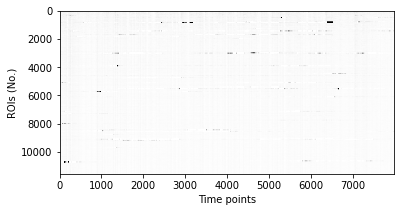

In [38]:
plt.figure(figsize=(6,3))
plt.imshow(dF_F, vmin = 0, vmax=3, aspect='auto', cmap='gray_r')
plt.xlabel('Time points')
plt.ylabel('ROIs (No.)')
plt.show()

(0.0, 50.0)

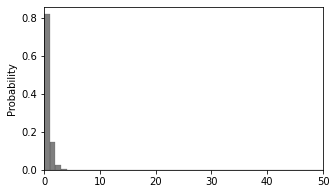

In [39]:
fig = plt.figure(figsize=(5, 3))
sns.histplot(np.max(dF_F, axis=1), binwidth=1, stat='probability', kde=False, color='k', alpha=.5, linewidth=0.2, edgecolor='.3');
plt.xlim(0,50)

In [40]:
# # Tuning thresholds
# clssify_parms['dF_F_threshold']=[0.5, 20]

In [41]:
outlier_ROI_fluo = np.where(np.mean(F,axis=1)-1.0*np.mean(F_neuropils, axis=1) < 0)[0]
iscell_2[outlier_ROI_fluo] = 0
outlier_ROI_dF_F = np.where((np.max(dF_F,axis=1)<clssify_parms['dF_F_threshold'][0])|(np.max(dF_F,axis=1)>clssify_parms['dF_F_threshold'][1]))[0]
iscell_2[outlier_ROI_dF_F] = 0

In [42]:
len(outlier_ROI_fluo), len(outlier_ROI_dF_F)

(3212, 9398)

### Signal and Noise

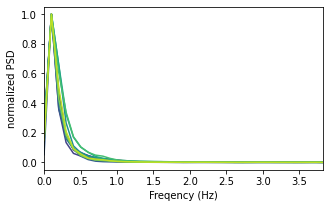

In [43]:
f, psd = post.calc_psd(dF_F, ops, db)
cellID = np.random.choice(dF_F.shape[0], size=10, replace=False)
cmap = plt.get_cmap('viridis')
fig = plt.figure(figsize=(5, 3))
for i, v in enumerate(cellID):
    plt.plot(f, psd[v], color=cmap(i/len(cellID)))
    plt.xlim(f.min(),f.max())
    plt.xlabel('Freqency (Hz)')
    plt.ylabel('normalized PSD')

Text(0, 0.5, 'Probability')

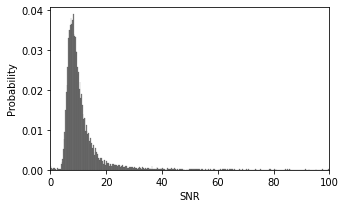

In [44]:
snr = post.calc_snr(dF_F, ops, db, signal_thr=0.5)
fig = plt.figure(figsize=(5, 3))
sns.histplot(snr, binwidth=0.25, stat='probability', kde=False, color='k', alpha=.5, linewidth=0.2, edgecolor='.3');
plt.xlim(0,100)
plt.xlabel('SNR')
plt.ylabel('Probability')

### Calculate mad

Text(0, 0.5, 'Probability')

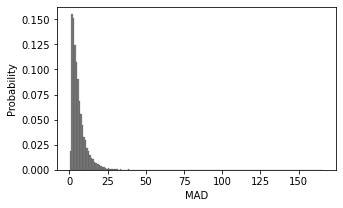

In [45]:
mad_max_min_ratio = post.calc_mad_ratio(dF_F)
fig = plt.figure(figsize=(5, 3))
sns.histplot(mad_max_min_ratio, binwidth=1, stat='probability', kde=False, color='k', alpha=.5, linewidth=0.2, edgecolor='.3');
# plt.xlim(0,20)
plt.xlabel('MAD')
plt.ylabel('Probability')

In [46]:
mad = stats.median_abs_deviation(dF_F, axis=1)
mad_norm_max = np.max((dF_F-np.tile(np.median(dF_F, axis=1), (dF_F.shape[1], 1)).T)/np.tile(mad, (dF_F.shape[1], 1)).T, axis=1)
mad_norm_min = abs(np.min((dF_F-np.tile(np.median(dF_F, axis=1), (dF_F.shape[1], 1)).T)/np.tile(mad, (dF_F.shape[1], 1)).T, axis=1))
mad_max_min_ratio = mad_norm_max/mad_norm_min

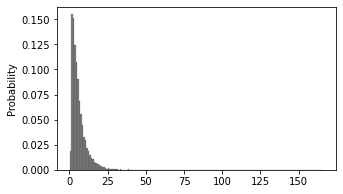

In [47]:
fig = plt.figure(figsize=(5, 3))
sns.histplot(mad_max_min_ratio, binwidth=1, stat='probability', kde=False, color='k', alpha=.5, linewidth=0.2, edgecolor='.3');

In [48]:
# # Tuning thresholds
# clssify_parms['snr_threshold']=0.8
# clssify_parms['mad_threshold']=2.5

In [49]:
# cellID = np.random.choice(np.where(snr<clssify_parms['snr_threshold'])[0], size=10, replace=False)
# # cellID = np.where(snr<snr_th)[0][:10]
# print('Number of low SNR ROIs:', len(np.where(snr<clssify_parms['snr_threshold'])[0]))
# fig = plt.figure(figsize=(5,5),tight_layout=True)
# for i, v in enumerate(cellID):
#     plt.plot(dF_F[v]+i*5, color='k', lw=0.5)

# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(True)
# plt.gca().spines['left'].set_visible(True)
# plt.gca().yaxis.set_ticks_position('left')
# plt.gca().xaxis.set_ticks_position('bottom')

In [50]:
# cellID = np.random.choice(np.where(mad_max_min_ratio<clssify_parms['mad_threshold'])[0], size=10, replace=False)
# # cellID = np.where(mad_max_min_ratio<mad_th)[0][:10]
# print('Number of low SNR ROIs:', len(np.where(mad_max_min_ratio<clssify_parms['mad_threshold'])[0]))
# fig = plt.figure(figsize=(5,5),tight_layout=True)
# for i, v in enumerate(cellID):
#     plt.plot(dF_F[v]+i*5, color='k', lw=0.5)

# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(True)
# plt.gca().spines['left'].set_visible(True)
# plt.gca().yaxis.set_ticks_position('left')
# plt.gca().xaxis.set_ticks_position('bottom')

In [51]:
outlier_ROI_snr = np.where(snr<clssify_parms['snr_threshold'])[0]
iscell_2[outlier_ROI_snr] = 0
# outlier_ROI_mad = np.where(mad_max_min_ratio<clssify_parms['mad_threshold'])[0]
# iscell_2[outlier_ROI_mad] = 0

### Classified ROIs

cell number: 925
non-cell number: 10620


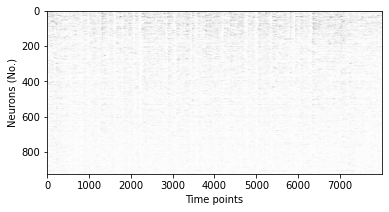

In [52]:
print('cell number:', len(np.where(iscell_2[:,1]==1)[0]))
print('non-cell number:', len(np.where(iscell_2[:,1]==0)[0]))
plt.figure(figsize=(6,3))
plt.imshow(dF_F[np.where(iscell_2[:,0]==1)[0]], vmin = 0, vmax=3, aspect='auto', cmap='gray_r')
plt.xlabel('Time points')
plt.ylabel('Neurons (No.)')
plt.show()

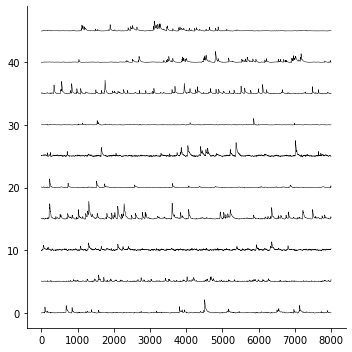

In [61]:
cellID = np.random.choice(np.where(iscell_2[:,0]==1)[0], size=10, replace=False)
fig = plt.figure(figsize=(5,5),tight_layout=True)
for i, v in enumerate(cellID):
    plt.plot(dF_F[v]+i*5, color='k', lw=0.5)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

In [54]:
np.save(analysisDir+'/suite2p/plane0/iscell.npy', iscell_2)

## Check ROI quality with GUI

In [55]:
!suite2p

/mnt/ssd1/ysaito/suite2p-pipeline-main/02_analysis/i166-m2_Exp01/01_ROI_detection_DeepCAD_all/suite2p/plane0/stat.npy
no channel 2 labels found (redcell.npy)
added enhanced mean image
time to draw and plot masks:  6.7606 sec


## Denoise & spike inference

In [62]:
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2

/home/ysaito/.conda/envs/suite2p/lib/python3.8/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [63]:
inf_parms = {
    's_min':.35
}
inf_parms

{'s_min': 0.35}

In [64]:
def plot_trace(time, dF_F, c, s, cellID):
    plt.figure(figsize=(10,5))
    plt.subplot(311)
    plt.plot(time, dF_F, label=cellID, zorder=-12, c='y')
    plt.legend(ncol=3, frameon=False, loc=(.02,.9))
    plt.xlim(time.min(), time.max()+10)
    plt.ylim(-0.2,3)
    simpleaxis(plt.gca())
    
    plt.subplot(312)
    plt.plot(time, c, lw=2, label='denoised')
    # plt.plot(time, dF_F, label='data', zorder=-12, c='y')
    plt.legend(ncol=3, frameon=False, loc=(.02,.9))
    plt.xlim(time.min(), time.max())
    plt.ylim(-0.2,3)
    simpleaxis(plt.gca())
    
    plt.subplot(313)
    plt.plot(time, s, lw=2, label='deconvolved', c='g')
    plt.ylim(0,1.5)
    plt.legend(ncol=3, frameon=False, loc=(.02,.9));
    simpleaxis(plt.gca())
    plt.xlim(time.min(), time.max())
    plt.xlabel('Time (sec)')
    plt.subplots_adjust(wspace=0.4, hspace=0.6)

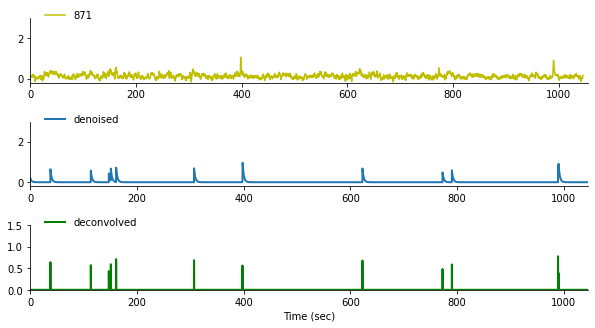

<Figure size 720x108 with 0 Axes>

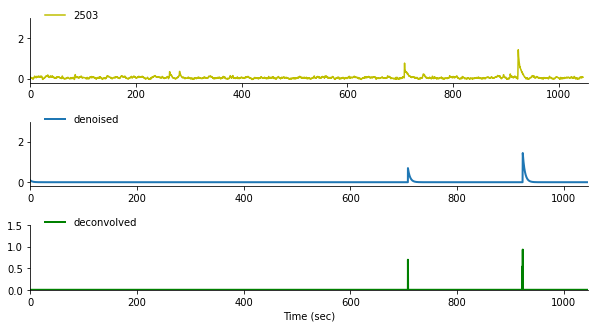

<Figure size 720x108 with 0 Axes>

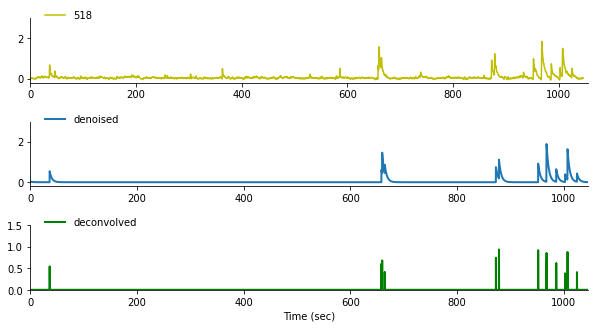

<Figure size 720x108 with 0 Axes>

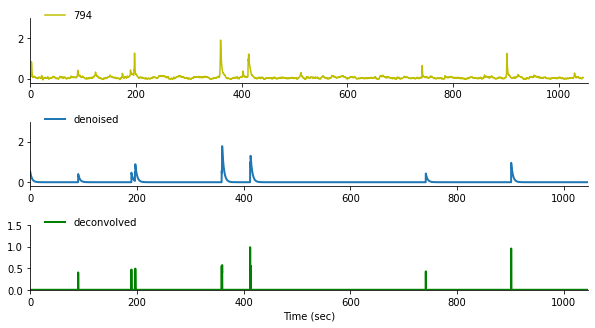

<Figure size 720x108 with 0 Axes>

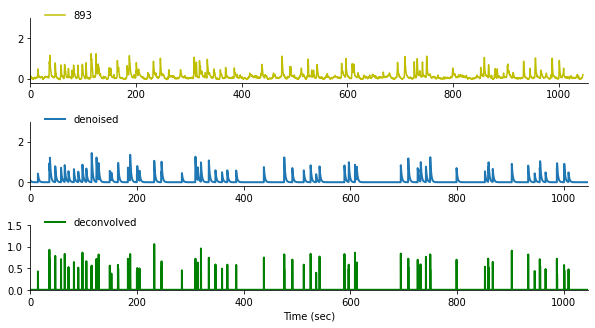

<Figure size 720x108 with 0 Axes>

In [70]:
# check parameter before apply oasis in whole data
cellID = np.random.choice(np.where(iscell_2[:,0]==1)[0], size=5, replace=False)
# cellID = np.where(iscell_2[:,0]==1)[0][0:10]
for i in cellID:
    c, s = oasisAR1(dF_F[i].astype('double'), g=estimate_parameters(dF_F[i], p=1)[0], s_min=inf_parms['s_min'])
    plot_trace(time, dF_F[i], c, s, i)
    plt.figure(figsize=(10,1.5))

In [66]:
%%time
denoise = []
deconv = []
for i in range(dF_F.shape[0]):
    c, s = oasisAR1(dF_F[i].astype('double'), g=estimate_parameters(dF_F[i], p=1)[0], s_min=inf_parms['s_min'])
    denoise.append(c)
    deconv.append(s)
denoise=np.array(denoise)
deconv=np.array(deconv)

CPU times: user 13 s, sys: 819 ms, total: 13.8 s
Wall time: 13.8 s


## Save results as h5

In [71]:
with h5py.File(analysisDir+'/suite2p/plane0/roi_data.h5', mode='w') as f:
    f.create_dataset('dF_F', data=dF_F)
    f.create_dataset('denoise', data=denoise)
    f.create_dataset('deconv', data=deconv)
    f.create_dataset('celluse', data=iscell_2[:,0].astype('int'))
    f.create_dataset('snr', data=snr)
    f.create_dataset('mad', data=mad_max_min_ratio)
    f.create_dataset('roi_size', data=ROI_npix)
    f.create_dataset('centroid', data=centroid) #1st column: x, 2nd column: y
    f.create_group('clssify_parms')
    for p in clssify_parms.keys():
        f.create_dataset('clssify_parms/'+p, data=clssify_parms[p])
    f.create_group('inf_parms')
    f.create_dataset('inf_parms/s_min', data=inf_parms['s_min'])  

In [104]:
## Code for loading data
# roi_data = h5py.File(out_path+'/suite2p/plane0/roi_data.h5', mode='r')
# dF_F = np.array(list(roi_data['dF_F']))
# denoise = np.array(list(roi_data['denoise']))
# deconv = np.array(list(roi_data['deconv']))
# celluse = np.array(list(roi_data['celluse']))
# snr = np.array(list(roi_data['snr']))
# mad = np.array(list(roi_data['mad']))
# centroid = np.array(list(roi_data['centroid']))
# ROI_size_threshold = roi_data['clssify_parms/ROI_size_threshold'][()]
# roi_data.close()